# PM2 — Task F: Sparsity & Reordering
Team: Camille Wardlaw, Manuel Valencia, Demircan Tas\
Scope: Task F (Sparsity Analysis and Matrix Reordering)

In [1]:
# Setup
import os, math, warnings
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy import sparse as sp
from scipy.sparse.linalg import svds, spsolve
from numpy.linalg import cond as dense_cond

np.set_printoptions(suppress=True, linewidth=120)
np.random.seed(0)
plt.rcParams.update({'figure.figsize': (7.5,4.5), 'axes.grid': True})
os.makedirs('temp/pm2', exist_ok=True)
warnings.filterwarnings('ignore')

In [2]:
# Project imports
from getParam_Sonar import getParam_Sonar
from eval_f_Sonar import eval_f_Sonar
from eval_Jf_Sonar import eval_Jf_Sonar
from eval_Jf_FiniteDifference import eval_Jf_FiniteDifference
from eval_g_Sonar import eval_g_Sonar
from eval_u_Sonar import eval_u_Sonar
from simpleLeapFrog import LeapfrogSolver

## Task F - Sparsity & Reordering

### a) How sparse are the matrices? Visualized the matrix with the sparsity and estimate the computational complexity for factoring it "as is" as well estimating an upper bound for the possible fill-ins that may occur?

[A] n=20,000, nnz(M)=69,600, density=1.740e-04
    envelopes on original pattern:
    lower envelope  ρ_L = 100,990,099
    upper envelope  ρ_U = 100,000,000
    total profile   ρ   = 201,010,099
    half-bandwidth  β   = 10,100


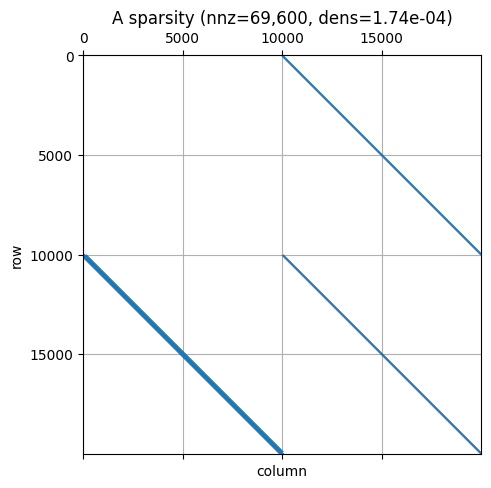

[A] Banded-LU upper bounds (as-is ordering):
    ~ flops ≤ 1.360e+12
    ~ nnz(LU) ≤ 4.040e+08  (vs nnz(A) = 69,600)


In [3]:
def to_csr(M):
    """Return CSR sparse matrix without copying big dense inputs unless needed."""
    if sp.issparse(M):
        return M.tocsr()
    M = np.asarray(M)
    return sp.csr_matrix(M)

def half_bandwidth(M):
    """
    Compute half-bandwidth β = max_{(i,j) in nz} |i - j| using the symmetric pattern.
    """
    M = to_csr(M)
    # symmetric pattern
    S = (M != 0).astype(np.int8)
    S = (S + S.T).astype(np.int8)
    S = S.tocoo()
    if S.nnz == 0:
        return 0
    return int(np.max(np.abs(S.row - S.col)))

def sparsity_stats(M, name="A", show=True, markersize=0.01, symmetrize=False):
    """
    Print sparsity, envelopes, and skyline profile for M.

    Envelopes are computed on the *symmetrized* pattern S = nz(M) ∪ nz(Mᵀ)
    (set symmetrize=False to use M's original pattern).

    For each row i with nonzeros in S:
      j_min(i) = leftmost column index
      j_max(i) = rightmost column index

    Lower envelope  ρ_L = Σ_i max(0, i - j_min(i))
    Upper envelope  ρ_U = Σ_i max(0, j_max(i) - i)
    Total profile   ρ   = ρ_L + ρ_U + n         (includes diagonal)
    Half-bandwidth  β   = max_i max(i - j_min(i), j_max(i) - i)

    Returns a dict with these quantities.
    """
    M = to_csr(M)
    n = M.shape[0]

    # Choose pattern to analyze
    P = (M != 0).astype(np.int8)
    if symmetrize:
        P = (P + P.T).astype(np.int8)
    P = P.tocsr()

    # Basic counts on the original matrix M (not the symmetrized pattern)
    nnz = M.nnz
    density = nnz / (n * n)

    # Row-wise envelopes
    indptr, indices = P.indptr, P.indices
    rho_L = 0  # lower (to the left of diag)
    rho_U = 0  # upper (to the right of diag)
    beta  = 0  # half-bandwidth

    for i in range(n):
        start, end = indptr[i], indptr[i+1]
        if end == start:
            continue  # empty row in pattern
        jmin = indices[start]
        jmax = indices[end - 1]
        # ensure monotone (CSR indices are sorted by row)
        dl = max(0, i - jmin)   # distance to leftmost nz
        du = max(0, jmax - i)   # distance to rightmost nz
        rho_L += dl
        rho_U += du
        if dl > beta: beta = dl
        if du > beta: beta = du

    rho_total = rho_L + rho_U + n  # include diagonal

    # Print report
    print(f"[{name}] n={n:,}, nnz(M)={nnz:,}, density={density:.3e}")
    print(f"    envelopes on {'symmetrized' if symmetrize else 'original'} pattern:")
    print(f"    lower envelope  ρ_L = {rho_L:,}")
    print(f"    upper envelope  ρ_U = {rho_U:,}")
    print(f"    total profile   ρ   = {rho_total:,}")
    print(f"    half-bandwidth  β   = {beta:,}")

    # Visualize sparsity of the original M
    if show:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.spy(M, markersize=markersize)
        ax.set_title(f"{name} sparsity (nnz={nnz:,}, dens={density:.2e})")
        ax.set_xlabel("column")
        ax.set_ylabel("row")
        plt.tight_layout()
        plt.show()

    return {
        "n": n,
        "nnz": nnz,
        "density": density,
        "lower_envelope": int(rho_L),
        "upper_envelope": int(rho_U),
        "profile_total": int(rho_total),
        "beta": int(beta),
        "symmetrized": bool(symmetrize),
    }

def lu_band_cost_upper_bounds(n, beta):
    """
    Common back-of-envelope bounds for banded LU *without pivoting*:
      - Flop count ~ (2/3) * n * beta^2
      - Storage (LU factors) ~ n * (2*beta + 1) nonzeros
    These are crude UPPER bounds; actual costs can be lower if solver does pivoting and reordering.
    """
    flops = (2/3) * n * (beta**2)
    nnz_LU_upper = n * (2*beta + 1)
    return int(flops), int(nnz_LU_upper)


# --- Analyze A ---------------------------------------
Nx, Nz, Lx, Lz = 100, 100, 100, 100
p, *_ = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=True)
A_csr = to_csr(p["A"])
stats_A = sparsity_stats(A_csr, name="A", show=True)

flops_A, nnzLU_A = lu_band_cost_upper_bounds(stats_A["n"], stats_A["beta"])
print(f"[A] Banded-LU upper bounds (as-is ordering):")
print(f"    ~ flops ≤ {flops_A:.3e}")
print(f"    ~ nnz(LU) ≤ {nnzLU_A:.3e}  (vs nnz(A) = {stats_A['nnz']:,})")

[L] n=10,000, nnz(M)=49,600, density=4.960e-04
    envelopes on original pattern:
    lower envelope  ρ_L = 990,099
    upper envelope  ρ_U = 990,099
    total profile   ρ   = 1,990,198
    half-bandwidth  β   = 100


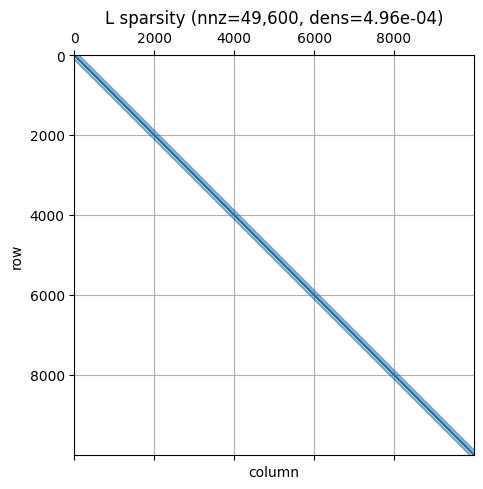

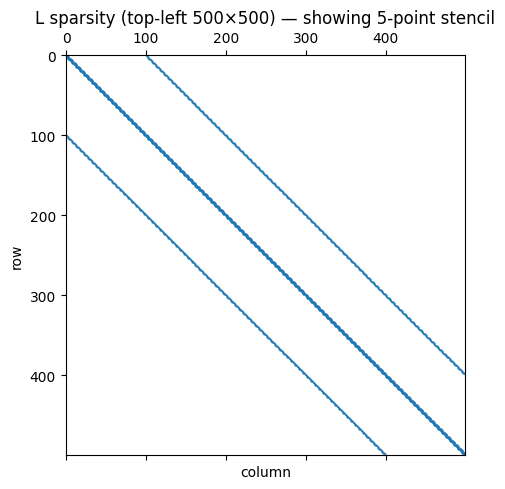

In [4]:
def extract_L_from_A(p):
    """Return L from block A = [[0, I],[c^2 L, -αI]]. If p['L'] exists, use it."""
    if 'L' in p:
        return to_csr(p['L'])

    A = to_csr(p['A'])
    n2 = A.shape[0]
    assert n2 % 2 == 0, "A must be 2N x 2N"
    N = n2 // 2

    # bottom-left block is c^2 * L  (same sparsity as L)
    L_tilde = A[N:, :N]              # CSR slice → CSR
    return L_tilde

# --- Analyze L ---------------------------------------
L_csr = extract_L_from_A(p)
stats_L = sparsity_stats(L_csr, name="L", show=True)

r = min(L_csr.shape[0], Nz * 5)
c = min(L_csr.shape[1], Nz * 5)
L_sub = L_csr[:r, :c]

fig, ax = plt.subplots(figsize=(5, 5))
ax.spy(L_sub, markersize=.5)
ax.set_xlabel("column")
ax.set_ylabel("row")
ax.set_title(f"L sparsity (top-left {r}×{c}) — showing 5-point stencil")
ax.set_xlim(-0.5, c-0.5)
ax.set_ylim(r-0.5, -0.5)  # keep origin at top-left visually
ax.grid(False)
plt.tight_layout()
plt.show()

In [5]:
from scipy.sparse.linalg import splu
# grid sizes to test
grids = [(10,10), (50,50), (100,100), (500,500)]
Lx = Lz = 100.0  # physical sizes (use whatever you've been using)

for Nx, Nz in grids:
    try:
        # build params and A (sparse)
        p, *_ = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=True)
        A = p["A"]
        if not sp.issparse(A):
            A = sp.csr_matrix(A)

        # time LU factorization (SuperLU)
        t0 = time.perf_counter()
        lu = splu(A.tocsc(), permc_spec="COLAMD", diag_pivot_thresh=1.0)
        t1 = time.perf_counter()

        print(f"LU(A) Nx={Nx:4d}, Nz={Nz:4d} | n={A.shape[0]:,} | time = {t1 - t0:.3f} s")
    except MemoryError:
        print(f"LU(A) Nx={Nx:4d}, Nz={Nz:4d} | n≈{(2*Nx*Nz):,} | SKIPPED (MemoryError)")
    except Exception as e:
        print(f"LU(A) Nx={Nx:4d}, Nz={Nz:4d} | ERROR: {type(e).__name__}: {e}")

LU(A) Nx=  10, Nz=  10 | n=200 | time = 0.000 s
LU(A) Nx=  50, Nz=  50 | n=5,000 | time = 0.004 s
LU(A) Nx= 100, Nz= 100 | n=20,000 | time = 0.022 s
LU(A) Nx= 500, Nz= 500 | n=500,000 | time = 1.381 s


Runtime grows roughly with the grid size because, in our natural ordering, the half-bandwidth is set by Nz (β≈Nz), so a banded LU has work ~ O(n·β²).
In practice, splu applies a fill-reducing ordering (e.g., COLAMD), which slashes effective bandwidth/fill so the observed scaling is closer to ~O(N^15) (e.g., quadrupling nodes → ~8× time).
So: Nz controls the band, and splu's reordering is why the timings remain fast until you reach multi-million unknowns.

### b) Estimate speed up if matrix were reordered.

Comparing splu natrual which does no reordering to splu COLMAD which handles reordering as well as reverse_cuthill_mckee.

In [6]:
from scipy.sparse.csgraph import reverse_cuthill_mckee

def to_csc(A): return A.tocsc() if sp.isspmatrix(A) else sp.csc_matrix(A)

def factor_time(A_csc, permc):
    t0 = time.perf_counter()
    lu = splu(A_csc, permc_spec=permc, diag_pivot_thresh=1.0)
    dt = time.perf_counter() - t0
    fill = (lu.L.nnz + lu.U.nnz) / A_csc.nnz  # How many more nonzeros in LU vs A
    return dt, fill

def run_reordering_speedup(Nx, Nz, Lx=100.0, Lz=100.0):
    p, *_ = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=True)
    A = p["A"];  A = A if sp.issparse(A) else sp.csr_matrix(A)
    A_csc = to_csc(A)

    # 1) Baseline: NATURAL (no column reordering)
    t_nat, fill_nat = factor_time(A_csc, "NATURAL")

    # 2) SuperLU's fill-reducing ordering: COLAMD
    t_colamd, fill_colamd = factor_time(A_csc, "COLAMD")

    # 3) Variable reordering: RCM on the (symmetrized) pattern, then NATURAL
    perm = reverse_cuthill_mckee((A != 0).astype(np.int8))
    A_rcm = A[perm][:, perm]
    t_rcm_nat, fill_rcm_nat = factor_time(to_csc(A_rcm), "NATURAL")

    print(f"Nx=Nz={Nx:4d} | n={A.shape[0]:,}")
    print(f"  NATURAL    : time={t_nat:8.3f}s  fill={fill_nat:6.2f}x")
    print(f"  COLAMD     : time={t_colamd:8.3f}s  fill={fill_colamd:6.2f}x  (speedup vs NATURAL ≈ {t_nat/max(t_colamd,1e-12):.1f}×)")
    print(f"  RCM+NATURAL: time={t_rcm_nat:8.3f}s  fill={fill_rcm_nat:6.2f}x  (speedup vs NATURAL ≈ {t_nat/max(t_rcm_nat,1e-12):.1f}×)")

# Example sweep (keep sizes reasonable to avoid OOM):
for n in [50, 100, 150, 200]:
    run_reordering_speedup(n, n)

Nx=Nz=  50 | n=5,000
  NATURAL    : time=   0.150s  fill=195.45x
  COLAMD     : time=   0.004s  fill=  6.89x  (speedup vs NATURAL ≈ 38.5×)
  RCM+NATURAL: time=   0.005s  fill= 14.07x  (speedup vs NATURAL ≈ 27.4×)
Nx=Nz= 100 | n=20,000
  NATURAL    : time=   3.437s  fill=747.49x
  COLAMD     : time=   0.020s  fill=  9.68x  (speedup vs NATURAL ≈ 172.0×)
  RCM+NATURAL: time=   0.051s  fill= 27.16x  (speedup vs NATURAL ≈ 67.2×)
Nx=Nz= 150 | n=45,000
  NATURAL    : time=  25.592s  fill=1656.67x
  COLAMD     : time=   0.056s  fill= 11.83x  (speedup vs NATURAL ≈ 460.8×)
  RCM+NATURAL: time=   0.218s  fill= 40.26x  (speedup vs NATURAL ≈ 117.5×)
Nx=Nz= 200 | n=80,000
  NATURAL    : time= 100.581s  fill=2923.00x
  COLAMD     : time=   0.110s  fill= 13.17x  (speedup vs NATURAL ≈ 918.4×)
  RCM+NATURAL: time=   0.622s  fill= 53.35x  (speedup vs NATURAL ≈ 161.6×)


In the natural ordering, the matrix's "band" is set by Nz, so elimination creates tons of new nonzeros ("fill"), making LU slow as the grid gets bigger. COLAMD (the default in splu) reorders the columns to reduce fill, so the factors are much sparser and the LU runs tens to hundreds of times faster. RCM (Reverse Cuthill–McKee) is a symmetric graph reordering that shrinks bandwidth; it helps, but not as much as COLAMD for our unsymmetric block system, so its speedups are smaller.